# JQA Subject Correlations

In [1]:
# Import necessary libraries.
import re, nltk, warnings, csv, sys, os, pickle, string, json
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import chain
from scipy import stats
import matplotlib.pyplot as plt

import itertools as iter
import networkx as nx
from networkx.algorithms import community
from networkx.readwrite import json_graph
from json import JSONEncoder
from operator import itemgetter
from collections import Counter

# Declare directory location to shorten filepaths later.
abs_dir = "/Users/quinn.wi/Documents/"

# Read in file; select columns; drop rows with NA values (entries without a named person).
df = pd.read_csv(abs_dir + 'Data/Output/ParsedXML/JQA_Subjects-dataframe.txt',
                 sep = '\t') \
    .drop(columns = ['file']) \
    .dropna()

# Unnest subject headings. 
df['subject'] = df['subject'].str.split(',')
df = df.explode('subject')

# Remove leading and trailing whitespace.
df['subject'] = df['subject'].str.strip()

# Remove rows with subject of "The".
df = df[~df['subject'].isin(['The'])]

print (f'Number of unique subject headings: {len(df["subject"].unique())}\nDF Shape: {df.shape}')

df.head()

Number of unique subject headings: 70
DF Shape: (5913, 4)


,entry,date,subject,text
0,jqadiaries-v30-1817-10-01,1817-10-01,Adams Family Residences,1. IV:30. Wednesday. Wrote a Letter to J. L. S...
0,jqadiaries-v30-1817-10-01,1817-10-01,Commerce,1. IV:30. Wednesday. Wrote a Letter to J. L. S...
1,jqadiaries-v30-1817-10-02,1817-10-02,Foreign Relations,2. IV: Continued drafting instructions for Rus...
1,jqadiaries-v30-1817-10-02,1817-10-02,Health and Illness,2. IV: Continued drafting instructions for Rus...
1,jqadiaries-v30-1817-10-02,1817-10-02,South American Wars of Independence,2. IV: Continued drafting instructions for Rus...


## Create Adjacency Matrix of Subjects

In [2]:
%%time

# Create adjacency matrix.
adj = pd.crosstab(df['entry'], df['subject'])

# Convert entry-person matrix into an adjacency matrix of persons.
adj = adj.T.dot(adj)

# Change same-same connections to zero.
np.fill_diagonal(adj.values, 0)

# Simple correlation matrix from dataframe.
adj = adj.corr()

adj

CPU times: user 71.8 ms, sys: 3.31 ms, total: 75.1 ms
Wall time: 74.1 ms


subject,Adams Family Finances,Adams Family Relations,Adams Family Residences,Adams-Onis Treaty,African Americans,American Revolution,Anglo-American Treaty of 1818,Anti-Slavery Movements,Asylum Movement,Bank of the United States,...,Telegraph,Texas Annexation (1845),Textile Industry,Treaty of Ghent,U.S. Constitution,Unitarianism,Utopian Communities,War of 1812,West,Westward Exploration and Expansion/Westward Migration/Manifest Destiny
subject,,,,,,,,,,,,,,,,,,,,,
Adams Family Finances,1.000000,0.727659,0.389086,0.540548,0.442506,0.656436,0.330066,0.094047,0.137007,0.484306,...,0.590463,0.247773,0.389686,0.680134,0.686979,0.247610,0.378965,0.704136,0.425385,0.325415
Adams Family Relations,0.727659,1.000000,0.715558,0.311554,0.383421,0.494437,0.288946,0.106255,0.104468,0.641129,...,0.612071,0.171720,0.379759,0.543494,0.549693,0.323803,0.365635,0.520659,0.261597,0.221636
Adams Family Residences,0.389086,0.715558,1.000000,0.297376,0.327417,0.394259,0.507395,0.098605,0.102312,0.755027,...,0.336900,0.038744,0.209861,0.469662,0.392169,0.186956,0.342076,0.433369,0.177391,0.141926
Adams-Onis Treaty,0.540548,0.311554,0.297376,1.000000,0.408091,0.737720,0.321435,0.147914,0.262829,0.624001,...,0.129122,0.600485,0.096739,0.792686,0.741195,0.149231,0.230885,0.792425,0.724156,0.638800
African Americans,0.442506,0.383421,0.327417,0.408091,1.000000,0.690818,0.299874,0.657218,0.081867,0.470132,...,0.254664,0.378373,0.531351,0.597908,0.582389,0.116564,0.485071,0.634079,0.429072,0.380009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Unitarianism,0.247610,0.323803,0.186956,0.149231,0.116564,0.315895,-0.088406,0.036235,-0.011590,0.150169,...,0.387541,-0.024704,0.048443,0.225145,0.186124,1.000000,0.285788,0.111137,0.118701,0.078077
Utopian Communities,0.378965,0.365635,0.342076,0.230885,0.485071,0.480707,0.105374,0.223772,-0.105951,0.389929,...,0.470046,0.144119,0.334082,0.515748,0.404429,0.285788,1.000000,0.439714,0.331617,0.193811
War of 1812,0.704136,0.520659,0.433369,0.792425,0.634079,0.823353,0.509615,0.284763,0.183938,0.733617,...,0.259341,0.517063,0.318979,0.848678,0.817205,0.111137,0.439714,1.000000,0.744042,0.641671


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


<Figure size 1152x864 with 0 Axes>

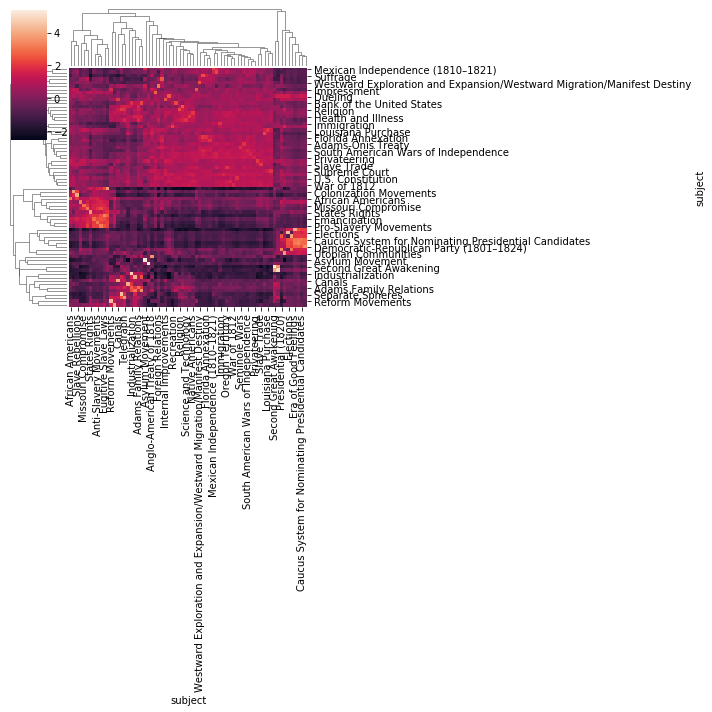

<Figure size 1152x864 with 0 Axes>

In [3]:
%time

sns.clustermap(adj, z_score = 1)

plt.figure(figsize=(16, 12))

## Save Subject Adj. as Network Object

In [4]:
%%time

adj['source'] = adj.index

df = pd.melt(adj, id_vars = ['source'], var_name = 'target', value_name = 'weight') \
    .query('(source != target) & (weight > 0.65)')

df

CPU times: user 7.07 ms, sys: 1.36 ms, total: 8.43 ms
Wall time: 7.13 ms


,source,target,weight
1,Adams Family Relations,Adams Family Finances,0.727659
5,American Revolution,Adams Family Finances,0.656436
23,Health and Illness,Adams Family Finances,0.732631
24,Immigration,Adams Family Finances,0.685282
32,Native Americans,Adams Family Finances,0.726324
...,...,...,...
4850,Florida Annexation,Westward Exploration and Expansion/Westward Mi...,0.720447
4869,Privateering,Westward Exploration and Expansion/Westward Mi...,0.692342
4879,Seminole Wars,Westward Exploration and Expansion/Westward Mi...,0.725668
4885,South American Wars of Independence,Westward Exploration and Expansion/Westward Mi...,0.702874


## Create Graph Object

In [5]:
%%time

# Initialize graph object.
G = nx.from_pandas_edgelist(df, 'source', 'target', 'weight')

# Add nodes.
nodes = list( dict.fromkeys( df['source'].values.tolist() + df['target'].values.tolist() ))
nodes = pd.DataFrame(nodes, columns = ['source'])
G.add_nodes_from(nodes)

print (nx.info(G))

# Set degree attributes.
nx.set_node_attributes(G, dict(G.degree(G.nodes())), 'degree')

# Sort nodes by degree and print top results.
sorted_degree = sorted(dict(G.degree(G.nodes())).items(),
                       key = itemgetter(1), reverse = True)

print ("Top 10 nodes by degree:")
for d in sorted_degree[:10]:
    print (f'\t{d}')


# Measure network density.
density = nx.density(G)
print (f"Network density: {density:.3f}")

# Related to diameter, check if network is connected and, therefore, can have a diameter.
print (f"Is the network connected? {nx.is_connected(G)}")

# Get a list of network components (communities).
# Find the largest component.
components = nx.connected_components(G)
largest_component = max(components, key = len)

# Create a subgraph of the largest component and measure its diameter.
subgraph = G.subgraph(largest_component)
diameter = nx.diameter(subgraph)
print (f"Network diameter of the largest component: {diameter:.3f}")

# Find triadic closure (similar to density).
triadic_closure = nx.transitivity(G)
print (f"Triadic closure: {triadic_closure:.3f}\n")

# Find centrality measures.
betweenness_dict = nx.betweenness_centrality(G) # Run betweenness centrality
eigenvector_dict = nx.eigenvector_centrality(G) # Run eigenvector centrality
degree_cent_dict = nx.degree_centrality(G)

# Assign each centrality measure to an attribute.
nx.set_node_attributes(G, betweenness_dict, 'betweenness')
nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')
nx.set_node_attributes(G, degree_cent_dict, 'degree_cent')


# Find communities.
communities = community.greedy_modularity_communities(G)

# Create a dictionary that maps nodes to their community.
modularity_dict = {}
for i, c in enumerate(communities):
    for name in c:
        modularity_dict[name] = i
        
# Add modularity information to graph object.
nx.set_node_attributes(G, modularity_dict, 'modularity')

Name: 
Type: Graph
Number of nodes: 58
Number of edges: 364
Average degree:  12.5517
Top 10 nodes by degree:
	('American Revolution', 31)
	('Privateering', 30)
	('Press', 29)
	('Treaty of Ghent', 29)
	('War of 1812', 29)
	('Commerce', 29)
	('Seminole Wars', 29)
	('U.S. Constitution', 28)
	('South American Wars of Independence', 26)
	('Supreme Court', 24)
Network density: 0.220
Is the network connected? False
Network diameter of the largest component: 7.000
Triadic closure: 0.715

CPU times: user 55.2 ms, sys: 2.13 ms, total: 57.3 ms
Wall time: 56.1 ms


## Write Graph Object

In [6]:
%%time


# Convert graph object into a dictionary.
data = json_graph.node_link_data(G)
    
data_json = json.dumps(data)

with open(abs_dir + "Data/Output/Graphs/JQA_Network_correlation/jqa-subjects-network.json", "w") as f:
    f.write(data_json)

CPU times: user 2.05 ms, sys: 900 µs, total: 2.95 ms
Wall time: 2.23 ms
